# DTSA 5509 Machine Learning - Supervised
## Final Project

### Introduction:

The purpose of this project is to create a machine learning model which can predict the approval status of a loan application at a lending institution. Because the data is already labeled and there is a target feature, this is a supervised machine learning project. As there are only two discrete outcomes, this problem will require a classification algorithm.

This is an important global problem at any lending institution, as many people around the world do not currently have the funds to buy outright buy houses, cars, start a business, etc. Evaluating a loan application can be a time-consuming process for a person and a predition model can not only speed up the process, but also be more consistent and fair than a person or several people may be in the process. A prediction model will be far less expensive to create and maintain in the long-term, so that the costs to lending institutions and to borrowers will be reduced.

The dataset I will be using for this project is obtained from:

Sharma, A. (2021). _Loan approval prediction dataset._ Kaggle. 

https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset. License: MIT 

License. https://www.mit.edu/~amini/LICENSE.md

It is described by the source as:
'The loan approval dataset is a collection of financial records and associated information used to determine the eligibility of individuals or organizations for obtaining loans from a lending institution. It includes various factors such as cibil score, income, employment status, loan term, loan amount, assets value, and loan status. This dataset is commonly used in machine learning and data analysis to develop models and algorithms that predict the likelihood of loan approval based on the given features.'

The dataset is 384kb in size, containing 13 columns and 4,269 rows. Data types for each feature are detailed in the EDA section. There was not much of a description of the data at all, therefore all of the following are my own interpretations:

loan_id - index 

no_of_dependents - I assume this means children, although it could include spouses or other family members.

education - graduate or not graduate, this could mean secondary school or higher.   

self_employed - whether a person holds a formal job or owns their own business. 

income_annum - annual income amount. No currency is mentioned.

loan_amount - self-explanatory. No currency is mentioned. 

loan_term - number of years over which a loan is to be amortized.   

cibil_score - I assume this is a credit score, a quick internet search tells me this is used in India. 

residential_assets_value - owned home value

commercial_assets_value - owned business value

luxury_assets - owned fancy things (maybe second homes, yachts, supercars?)

bank_asset_value - account balances and financial instruments

loan_status - This is the TARGET - whether or not a loan application is approved.

In [1]:
# packages and libraries used in this project:

# data handling
import pandas as pd
import numpy as np

# my functions
import projectfunctions as cf

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# machine learining stuffs
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# feature selection
from sklearn.feature_selection import SelectKBest, chi2, RFECV
from statsmodels.stats.outliers_influence import variance_inflation_factor

#evaluation metrics
from sklearn.metrics import  ConfusionMatrixDisplay, classification_report, accuracy_score, confusion_matrix, roc_curve, auc, RocCurveDisplay

In [2]:
# load data
data = pd.read_csv('loan_approval_dataset.csv')

# view first few lines
data.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


### Initial Exploratory Data Analysis:

In [3]:
data.describe(include = 'all')

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
count,4269.000000,4269.000000,4269,4269,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4269
unique,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,Graduate,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Approved
freq,NaN,NaN,2144,2150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2656
mean,2135.000000,2.498712,NaN,NaN,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06,NaN
std,1232.498479,1.695910,NaN,NaN,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06,NaN
min,1.000000,0.000000,NaN,NaN,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00,NaN
25%,1068.000000,1.000000,NaN,NaN,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06,NaN
50%,2135.000000,3.000000,NaN,NaN,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06,NaN
75%,3202.000000,4.000000,NaN,NaN,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


#### Some observations about the data:
* no columns are missing data. were there any missing values, they could be imputed within the data transformers section further on in the process.
* loan_id will be dropped, as there's no need for 2 indices
* looking at the column of column names, there appears to be a leading space in some of the column names. These will need to be stripped out during cleaning.
* columns 4:11 (income_annum:bank_asset_value) are numerical and will need to be scaled in preprocessing.
* no_of_dependents is a numerical column, but will need to be converted to categorical.


Now to have a look at the object columns and the unique values of their contents:

In [5]:
obj_cols = data.select_dtypes(include = 'object').columns

for column in obj_cols:
    unique_values = data[column].unique()
    print(f'''Unique values in column '{column}': {unique_values}''')

Unique values in column ' education': [' Graduate' ' Not Graduate']
Unique values in column ' self_employed': [' No' ' Yes']
Unique values in column ' loan_status': [' Approved' ' Rejected']


#### Some more observations about the data:
* I can see there are leading spaces in the string values. These will have to be stripped out during cleaning.
* There are only 2 values each for education and self-employed. These could be converted to binary values, or can be treated as categorical.
* Loan status is the target column with only 2 values, meaning this is a <u>binary classification problem </u>.

### Data Cleaning:

* I created a custom function to strip the leading spaces out of the column names and out of the object columns.
* The data was quite clean to begin with, so nothing else was required.
* If there were any missing values that needed to be imputed, they would be dealt with by the column transformer within my pipeline (see section below on data transformers).

In [6]:
# remove spaces
data = cf.strip_spaces(data)

### Time to split the data into training and testing sets, and separate the data into X and y variables

I like to split the data early on before it gets handled very much - we don't want to snoop, afterall!

In [7]:
# split data
train_df, test_df = train_test_split(data, test_size = 0.20, random_state = 2024)

In [8]:
# separate X and y variables
X_train = train_df.drop(columns = 'loan_status')
y_train = train_df['loan_status']
X_test = test_df.drop(columns = 'loan_status')
y_test = test_df['loan_status']

### More Exploratory Data Analysis

#### Loan status is the target
Lets take a look at how the data is distributed:

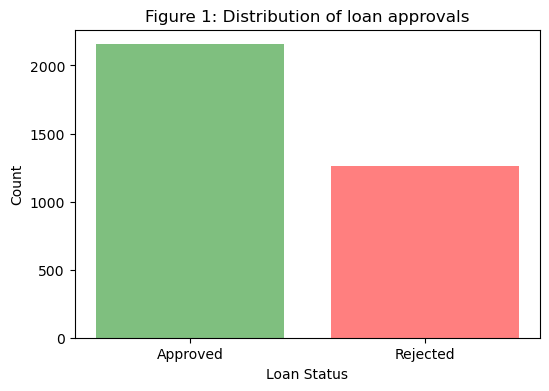

In [9]:
sorted_aprov_counts = train_df['loan_status'].value_counts().sort_values(ascending=False)

colors = ['green' if loan_status == 'Approved' else 'red' for loan_status in sorted_aprov_counts.index]

plt.figure(figsize=(6, 4))
plt.bar(sorted_aprov_counts.index, sorted_aprov_counts.values, color=colors, alpha=0.5)
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Figure 1: Distribution of loan approvals')
plt.show()

##### Class imbalance:

Here we have a class imbalance. Imbalanced target data could cause the model to be biased towards the larger proportion of data, in this case, it is Approved status. Within the sklearn libraries, RBF SVM and Random Forest support class weights, kNN does not. Other methods to address class imbalanced could be resampling techniques, emsembling methods, and using different evaluation metrics. The method for addressing this imbalance will be chosen pending model selection.


### Distribution of the categorical variables

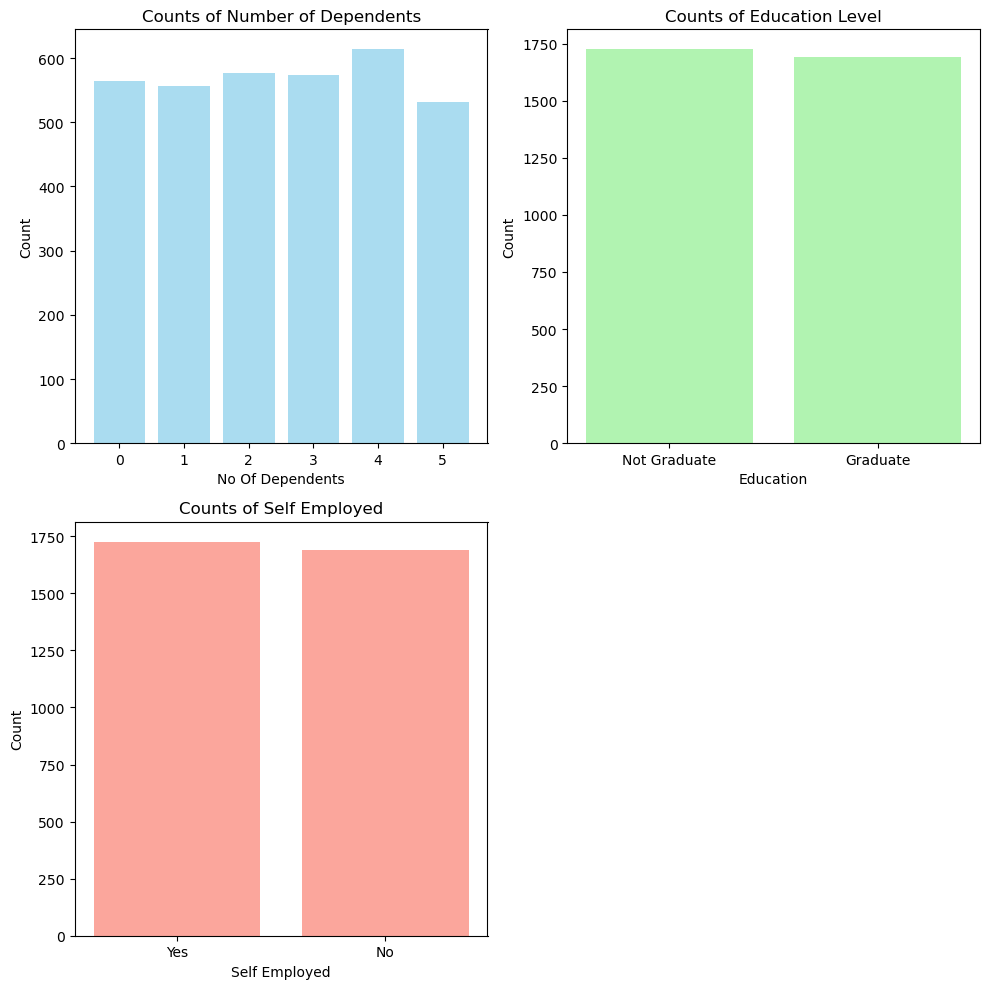

In [10]:


# columns to plot
columns = ['no_of_dependents', 'education', 'self_employed']
colors = ['skyblue', 'lightgreen', 'salmon']
titles = ['Counts of Number of Dependents', 'Counts of Education Level', 'Counts of Self Employed']

# create a figure and axis objects with a 3 x 1 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs = axs.flatten()

# loop through columns and plot
for i, col in enumerate(columns):
    counts = train_df[col].value_counts()
    axs[i].bar(counts.index, counts.values, color=colors[i], alpha=0.7)
    axs[i].set_xlabel(col.replace('_', ' ').title())
    axs[i].set_ylabel('Count')
    axs[i].set_title(titles[i])
    
axs[3].axis('off') 

# adjust layout
plt.tight_layout()

# show plot
plt.show()


Upon viewing the distribution of the categorical columns, I can see that they are all relatively balanced. I suspect that they don't carry much explanatory power, and their use will be determined based on their importance during the feature selection process. 

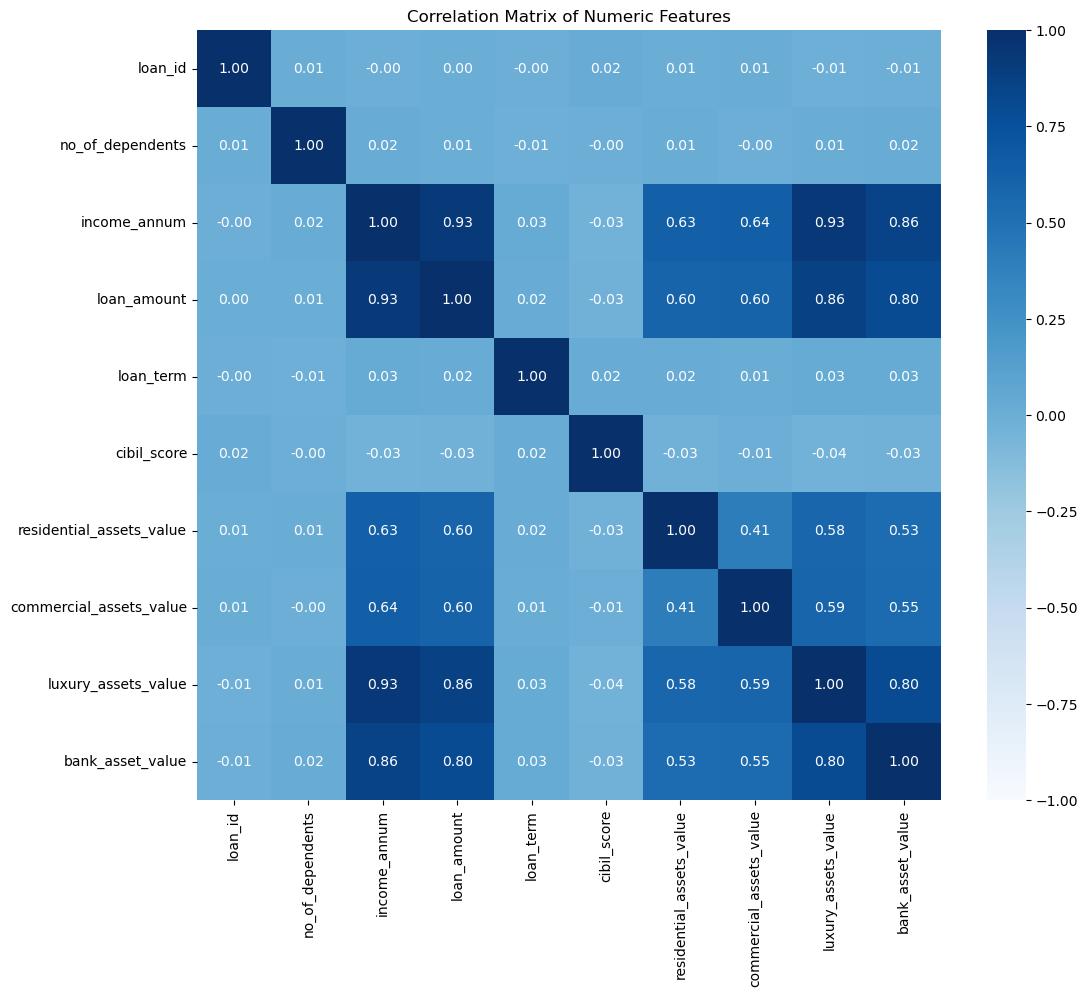

In [39]:
# select only num columns
numeric_features = train_df.select_dtypes(include=[np.number])

# correlation matrix
corr = numeric_features.corr()

# heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

This heatmap shows that some of the numeric features are highly correlated with each other. While this is a classification problem and not a linear regression problem, multicollinearity is still an issue. These features will also be assessed in the feature selection process.

## Modelling:

For the first iteration of modeling, I'll use all the features (except for loan_id) just for funsies to see what happens. The features need to be classified into appropriate categories, and if features will e dropped it can be specified here as well.

In [12]:
# categorize feats 

drop_feats = ['loan_id']

categorical_feats = ['education', 'self_employed',
              'no_of_dependents']

numeric_feats = ['income_annum', 'loan_term', 'cibil_score', 'loan_amount', 
              'luxury_assets_value',
              'bank_asset_value', 'residential_assets_value', 
                 'commercial_assets_value']

binary_feats = []

#### Data transformers:

The code cell below specifies how each type of features will be treated. Because I like to handle the data as little as possible before doing a train_test_split, I need a way to consistently process both the training and testing data after a split: SkLearn's Pipeline and Preprocessing modules are extremely convenient for this. While there are no missing values within my dataset, imputing missing values has been left in so that this framework may be again used on a broader range of datasets.
* OneHot encoding is used to categorical and binary features
* Numerical data needs to be scaled so that the different features are put on a level playing field.

In [13]:
# specify transformers - all rounds of modelling

categorical_transformer = make_pipeline(SimpleImputer(strategy = 'most_frequent'),
                                       OneHotEncoder(dtype = int, 
                                                     handle_unknown = 'ignore'))
                                        
numeric_transformer = make_pipeline(SimpleImputer(strategy = 'median'),
                                   (StandardScaler()))
 
                                  
binary_transformer = make_pipeline(SimpleImputer(strategy = 'most_frequent'), 
                                                 OneHotEncoder(drop = 'if_binary',
                                                 dtype = int,
                                                 sparse_output = False))


#### Preprocessor:

In [14]:
# create pre-processor - this needs to be respecified at each modelling iteration

preprocessor = make_column_transformer((categorical_transformer, categorical_feats),
        (numeric_transformer, numeric_feats),
        (binary_transformer, binary_feats),
        ('drop', drop_feats),                              
        remainder='passthrough')

#### Models to consider:

* I'll consider some of the classification models used in the course: SVM, kNN, and Random Forest (ensemble of decision trees)
* Dummy classifier, using the most-frequent strategy, will give us a baseline for minimum performance of our models.

In [15]:
models = { 
    'Dummy Classifier': DummyClassifier(strategy = 'most_frequent'),
    'RBF SVM': SVC(class_weight = 'balanced', random_state = 2024),
    'kNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(class_weight = 'balanced', random_state = 2024)    
        
        }

#### Modelling - Round 1

At this step, I'll build a pipeline, get 5-fold cross-validation scores of the training models, and store the results. 

In [16]:

results1 = []

for model_name, model in models.items():

    # pipeline
    model_selection_pipe = make_pipeline(preprocessor, model)
    
    # cross validation
    scores = cross_validate(model_selection_pipe, X_train, y_train, cv=5, return_train_score=True)

    # collect results
    model_results = {
        'model': model_name,
        'mean_train_accuracy': round(scores["train_score"].mean(), 4),
        'mean_validation_accuracy': round(scores["test_score"].mean(), 4),
        'mean_fit_time (s)': round(scores["fit_time"].mean(), 4),
        'mean_score_time (s)': round(scores["score_time"].mean(), 4)
    }
    
    results1.append(model_results)

results_df1 = pd.DataFrame(results1)

results_df1

,model,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s)
0,Dummy Classifier,0.6310,0.6310,0.0099,0.0041
1,RBF SVM,0.9505,0.9350,0.0775,0.0341
2,kNN,0.9329,0.8899,0.0119,0.0390
3,Random Forest,1.0000,0.9751,0.2393,0.0108


#### Round 1 results:

Not bad over-all, then again, it's a pretty simple model to begin with. The best performing model at this point is the random forest, followed by the RBF SVM, kNN, and lastly the dummy classifier.

The kNN classifier has the greatest difference between the mean training and validation accuracies - this indicates that the kNN model may be overfitting the data and may not generalize as well on other data.

### Feature Selection - Categorical
Now lets evaluate the categorical features and see how much we can reduce noise in the data and improve performance. As noted during the EDA process, I suspected that these features wouldn't be very important as there wasn't much difference between the values within each feature.

To more formally assess the features, I will use the Chi-Squared test (a high chi-squared value could be considered upwards of 10 to 20) and p-values (at a significance level of $\alpha = 0.05$) to determine how significant they are.


In [17]:
# from above...
categorical_feats = ['education', 'self_employed', 'no_of_dependents']

# label encode the cat feats so chi2 will work
label_encoders = {}
X_train_encoded = X_train.copy()

for col in categorical_feats:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train[col])
    label_encoders[col] = le

# chi-sqr test
chi2_scores, p_values = chi2(X_train_encoded[categorical_feats], y_train)

# result to df
chi2_df = pd.DataFrame({
    'feature': categorical_feats,
    'chi-sqr score': chi2_scores,
    'p-value': p_values
})


chi2_df

,feature,chi-sqr score,p-value
0,education,0.209441,0.647206
1,self_employed,0.019571,0.888741
2,no_of_dependents,0.386087,0.534363


#### Evaluation of categorical features:

In the above cell I calculated the chi-squared and p-values of each of the categorical features to determine their statistical significance. The chi-squared score measures the strength of association between each feature and the target variable, and a high chi-squared score indicates a stronger relationship. The p-values will indicate the probability that the observed association is by chance, and a low p-value would indicate that the feature is statistically significant in its association with the target feature.

In the results above, the categorical features 'education', 'self_employed', and 'no_of_dependents' all have very low chi-squared values of less than 1, indicating that none of them are strongly associated with the target 'loan_status'. The p-values for the categorical features are all much higher than the pre-specified $\alpha = 0.05$, which indicates that the observed associations with the target are not statistically significant.

As determined by these results, all three of 'education', 'self_employed', and 'no_of_dependents' will be added to the drop_features list

### Modelling - Round 2

Now that some features will be removed, I'd like to do another round of modelling to see how the model performs.

In [18]:
# add dropped feats
drop_feats = ['loan_id', 'education', 'self_employed', 'no_of_dependents']
categorical_feats = []

results2 = []

# re-define preprocessor

preprocessor = make_column_transformer((categorical_transformer, categorical_feats),
        (numeric_transformer, numeric_feats),
        (binary_transformer, binary_feats),
        ('drop', drop_feats),                              
        remainder='passthrough')
 
for model_name, model in models.items():

    # pipeline
    model_selection_pipe = make_pipeline(preprocessor, model)
    
    # cross validation
    scores = cross_validate(model_selection_pipe, X_train, y_train, cv=5, return_train_score=True)

    # collect results
    model_results = {
        'model': model_name,
        'mean_train_accuracy': round(scores["train_score"].mean(), 4),
        'mean_validation_accuracy': round(scores["test_score"].mean(), 4),
        'mean_fit_time (s)': round(scores["fit_time"].mean(), 4),
        'mean_score_time (s)': round(scores["score_time"].mean(), 4)
    }
    
    results2.append(model_results)
results_df2 = pd.DataFrame(results2)



In [19]:
# view round 2 results
results_df2

,model,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s)
0,Dummy Classifier,0.6310,0.6310,0.0058,0.0027
1,RBF SVM,0.9458,0.9353,0.0653,0.0297
2,kNN,0.9546,0.9236,0.0086,0.0302
3,Random Forest,1.0000,0.9816,0.2121,0.0082


In [20]:
results_df1 = results_df1.set_index('model')
results_df2 = results_df2.set_index('model')


In [21]:
# differences after removal of categorical features
compare1_2 = results_df2 - results_df1

compare1_2

,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s)
model,,,,
Dummy Classifier,0.0000,0.0000,-0.0041,-0.0014
RBF SVM,-0.0047,0.0003,-0.0122,-0.0044
kNN,0.0217,0.0337,-0.0033,-0.0088
Random Forest,0.0000,0.0065,-0.0272,-0.0026


### Comparing first and second round training and validation results

There was a very small decrease in the mean training accuracy and very small increase in the validation accuracy under the RBF SVM model after the education, number of dependents, and employment features were removed.

There was a small increase in the mean training and validation accuracies under the kNN model, and a very small increase in the mean validation accuracy under the random forest model.

Random forest is still the relatively best performing model.

Fit and score times were reduced slightly when the features were removed. This could be an important consideration when big data models are constructed, but this is just a wee little dataset. I'll give no further consideration to the times moving forwards.


### Feature Selection - Numerical

Now I'll evaluate the numerical features. As noted upon creating the correlation matrix earlier, there was some strong collinearity between the numerical features. To formally assess the multicollinearity, I will calculate the Variance Inflation Factors, or VIF (a high VIF to indicate multicollinearity could be considered to be around 5 to 10).

In [22]:
# df for results
vif_data = pd.DataFrame()
vif_data['feature'] = X_train[numeric_feats].columns

# vif for each feat
vif_data['VIF'] = [variance_inflation_factor(X_train[numeric_feats].values, i) for i in range(len(X_train[numeric_feats].columns))]

vif_data.sort_values(by = 'VIF', ascending = False)

,feature,VIF
0,income_annum,73.980969
4,luxury_assets_value,27.493059
3,loan_amount,27.463015
5,bank_asset_value,12.444291
2,cibil_score,5.063267
1,loan_term,3.924715
6,residential_assets_value,3.845542
7,commercial_assets_value,3.844393


#### Evaluation of numerical features:

In the results above, the worst offenders for multicollinearity are 'income_annum', 'luxury_assets_value', 'loan_amount', and 'bank_asset_value'. Intuitively this makes sense because a borrower with a higher income is likely to also have more luxury, banking assets, and afford more loans than a borrower with a lower income. 

The features 'loan_term', 'residential_assets_value' and 'commercial_assets_value' have low VIF below the pre-specified factor of 5 through 10. 'cibil_score' is on the edge of indicating collinearity. I will remove some of the worst offenders and see how that effects the VIF of 'cibil_score'.

I suspect, from personal experience, that income_annum would be highly important in determining a borrower's loan approval status. If I knew anyone in the banking industry, I could consult their industry expertise to determine which factors would be the most important in a model. For now, I will go with my intuition and remove 'luxury_assets_value' and 'bank_asset_value' and reassess the VIFs.

In [23]:
numeric_feats = ['income_annum', 'loan_term', 
                 'cibil_score', 'loan_amount', 
                 'residential_assets_value', 
                 'commercial_assets_value']

# df for results
vif_data2 = pd.DataFrame()
vif_data2['feature'] = X_train[numeric_feats].columns

# vif for each feat
vif_data2['VIF'] = [variance_inflation_factor(X_train[numeric_feats].values, i) for i in range(len(X_train[numeric_feats].columns))]

vif_data2.sort_values(by = 'VIF', ascending = False)

,feature,VIF
0,income_annum,34.242230
3,loan_amount,27.461309
2,cibil_score,5.058730
1,loan_term,3.924005
5,commercial_assets_value,3.843643
4,residential_assets_value,3.841435


After dropping the luxury and commercial asset features, the VIF for income dropped significantly. I'll drop 'loan_amount' next and reassess the VIFs.

In [24]:
numeric_feats = ['income_annum', 'loan_term', 'cibil_score', 
                 'residential_assets_value', 'commercial_assets_value']

# df for results
vif_data3 = pd.DataFrame()
vif_data3['feature'] = X_train[numeric_feats].columns

# vif for each feat
vif_data3['VIF'] = [variance_inflation_factor(X_train[numeric_feats].values, i) for i in range(len(X_train[numeric_feats].columns))]

vif_data3.sort_values(by = 'VIF', ascending = False)

,feature,VIF
0,income_annum,9.034713
2,cibil_score,5.058586
1,loan_term,3.923893
4,commercial_assets_value,3.838758
3,residential_assets_value,3.836360


... and now I'm curious to see what happens when loan amount is included and income is removed...

In [25]:
numeric_feats = ['loan_term', 'cibil_score', 'loan_amount',
                 'residential_assets_value', 'commercial_assets_value']

# df for results
vif_data4 = pd.DataFrame()
vif_data4['feature'] = X_train[numeric_feats].columns

# vif for each feat
vif_data4['VIF'] = [variance_inflation_factor(X_train[numeric_feats].values, i) for i in range(len(X_train[numeric_feats].columns))]

vif_data4.sort_values(by = 'VIF', ascending = False)

,feature,VIF
2,loan_amount,7.245586
1,cibil_score,4.933899
0,loan_term,3.897823
3,residential_assets_value,3.601614
4,commercial_assets_value,3.598940


Upon dropping income and including loan amount, the VIFs dropped significantly (I was wrong!). While the loan amount is sort of in the middle of the pre-specified 'high VIF' range, it's still below the value of 10, so I'll keep it.

In [26]:
# redefine features
drop_feats = ['loan_id', 'education', 'self_employed',
              'no_of_dependents', 'income_annum', 'luxury_assets_value', 'bank_asset_value']

categorical_feats = []

numeric_feats = ['loan_term', 'cibil_score', 'loan_amount', 
                 'residential_assets_value', 'commercial_assets_value']

binary_feats = []

results3 = []

# redefine preprocessor
preprocessor = make_column_transformer((categorical_transformer, categorical_feats),
        (numeric_transformer, numeric_feats),
        (binary_transformer, binary_feats),
        ('drop', drop_feats),                              
        remainder='passthrough')




for model_name, model in models.items():

    # pipeline
    model_selection_pipe = make_pipeline(preprocessor, model)
    
    # cross validation
    scores = cross_validate(model_selection_pipe, X_train, y_train, cv=5, return_train_score=True)

    # collect results
    model_results = {
        'model': model_name,
        'mean_train_accuracy': round(scores["train_score"].mean(), 4),
        'mean_validation_accuracy': round(scores["test_score"].mean(), 4),
        'mean_fit_time (s)': round(scores["fit_time"].mean(), 4),
        'mean_score_time (s)': round(scores["score_time"].mean(), 4)
    }
    
    results3.append(model_results)

results_df3 = pd.DataFrame(results3)

results_df3

,model,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s)
0,Dummy Classifier,0.6310,0.6310,0.0085,0.0038
1,RBF SVM,0.9428,0.9356,0.0671,0.0276
2,kNN,0.9570,0.9247,0.0081,0.0267
3,Random Forest,1.0000,0.9672,0.1881,0.0076


In [27]:
# compare differences after removal of some numerical features
results_df3 = results_df3.set_index('model')

compare2_3 = results_df3 - results_df2

compare2_3

,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s)
model,,,,
Dummy Classifier,0.0000,0.0000,0.0027,0.0011
RBF SVM,-0.0030,0.0003,0.0018,-0.0021
kNN,0.0024,0.0011,-0.0005,-0.0035
Random Forest,0.0000,-0.0144,-0.0240,-0.0006


#### Comparing second and third round training and validation results

There was a very small decrease in the mean training accuracy and very small increase under the RBF SVM model after the income, luxury and bank asset features were removed.

There was a very small increase in the mean training and validation accuracies under the kNN model, and a very small decrease in the mean validation accuracy under the random forest model.

### Model Selection

Random forest has the best training and validation accuracy among the models listed. As such, this will be my choice and will tune some hyperparameters to further improve its performance.


#### Hyperparameter tuning

sklearn's rf has a lot of hyperparameters to tune. I'll select three basic hyperparameters: number of estimators, max depth, and minimum samples required to split.

In [28]:
# define pipeline
rf_pipe = make_pipeline(preprocessor, RandomForestClassifier(class_weight = 'balanced', random_state = 2024))

# sweep over hyperparameters in rf_param_grid
rf_param_grid = {'randomforestclassifier__n_estimators': range(10, 21, 1),
                 'randomforestclassifier__max_depth': range(1, 21, 1),
                 'randomforestclassifier__min_samples_split': range(2, 21, 1)
                }

rf_search = RandomizedSearchCV(rf_pipe, 
                                  rf_param_grid, 
                                  cv = 5, 
                                  n_iter = 5,
                                  n_jobs = -1,
                                  return_train_score = True,
                                  random_state = 2024)


rf_search.fit(X_train, y_train)

C:\Users\bergs\miniconda3\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(dtype=<class 'int'>,
                                                                                                              handle_unknown='ignore'))]),
                                                                               []),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                Simple...
                                                                                'bank_asset_value'])])),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=2024))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(1, 21),
                                        'randomforestclassifier__min_samples_split': range(2, 21),
                                        'randomforestclassifier__n_estimators': range(10, 21)},
                   random_state=2024, return_train_score=True)

In [29]:
# resluts
rf_grid_results = rf_search.cv_results_
rf_grid_results = pd.DataFrame(rf_grid_results)
rf_grid_results = (rf_grid_results.loc[:,['mean_test_score',
                                          'param_randomforestclassifier__n_estimators',
                                          'param_randomforestclassifier__max_depth',
                                          'param_randomforestclassifier__min_samples_split',
                                          'mean_fit_time',
                                          'rank_test_score']]
                            .sort_values(by = 'rank_test_score'))     
rf_grid_results 

,mean_test_score,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,param_randomforestclassifier__min_samples_split,mean_fit_time,rank_test_score
3,0.966032,18,12,19,0.079142,1
2,0.965447,14,13,18,0.069909,2
0,0.963982,13,18,4,0.073774,3
1,0.962811,15,13,15,0.081027,4
4,0.951977,17,1,18,0.054997,5


In [30]:
best_rf = rf_search.best_params_
best_rf_score = round(rf_search.best_score_, 4)

print(best_rf)
print(best_rf_score)

{'randomforestclassifier__n_estimators': 18, 'randomforestclassifier__min_samples_split': 19, 'randomforestclassifier__max_depth': 12}
0.966


#### Visualizing hyperparameter search:

I changed the hyperparameters manually a few times in the code above. I realized visualizing the mean test score might speed up the process...

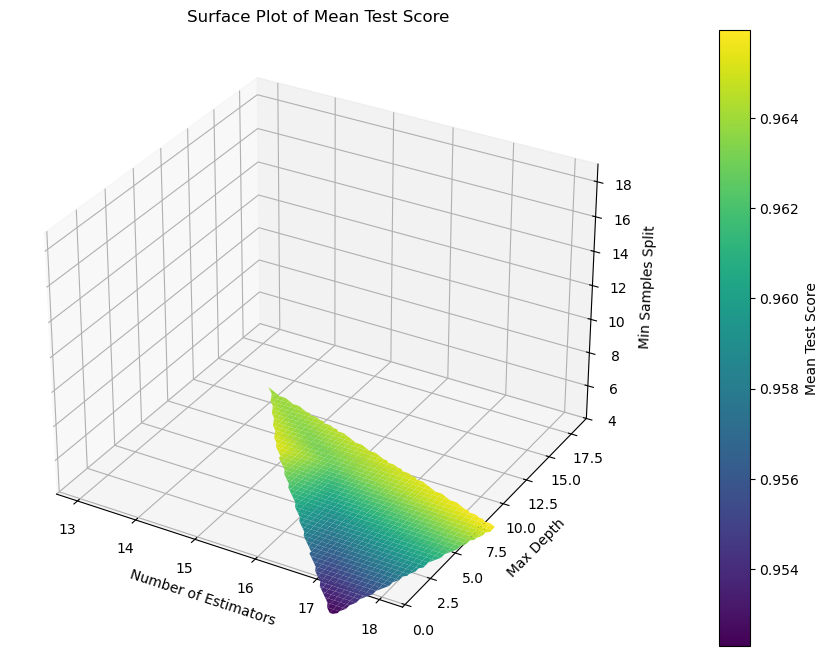

In [31]:
# axes to plot
x = rf_grid_results['param_randomforestclassifier__n_estimators']
y = rf_grid_results['param_randomforestclassifier__max_depth']
z = rf_grid_results['param_randomforestclassifier__min_samples_split']
c = rf_grid_results['mean_test_score']

# grid points for x and y
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 100), 
    np.linspace(y.min(), y.max(), 100)
)

# Interpolate mean test scores over the grid for x and y
grid_c = griddata(
    (x, y), c, 
    (grid_x, grid_y), 
    method = 'linear'
)

# Create a new grid for z-axis
grid_z = np.linspace(z.min(), z.max(), 100)

# Plot the surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# surface plot
surf = (ax.plot_surface(grid_x, 
                        grid_y, 
                        grid_c, 
                        cmap = 'viridis', 
                        edgecolor = 'none'))

# labels
ax.set_xlabel('Number of Estimators')
ax.set_ylabel('Max Depth')
ax.set_zlabel('Min Samples Split')
ax.set_title('Surface Plot of Mean Test Score')

# Set z-ticks manually to the specified range
ax.set_zlim(z.min(), z.max())
ax.set_zticks(np.arange(z.min(), z.max()+1, 2))  

# color bar
cbar = plt.colorbar(surf, pad=0.1)
cbar.set_label('Mean Test Score')

plt.show()


## Model Evaluation

It's the moment of truth - how does this model actually perform on unseen data?

In [32]:
rf_test_score = rf_search.score(X_test, y_test)
rf_test_score

0.9707259953161592

#### Confusion Matrix

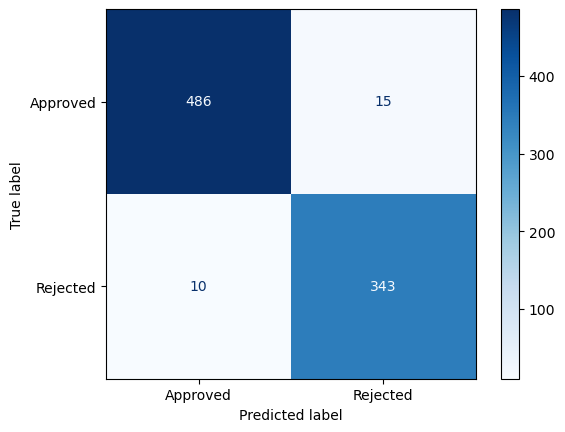

              precision    recall  f1-score   support

    Approved       0.98      0.97      0.97       501
    Rejected       0.96      0.97      0.96       353

    accuracy                           0.97       854
   macro avg       0.97      0.97      0.97       854
weighted avg       0.97      0.97      0.97       854



In [33]:
y_pred = rf_search.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

rf_cm_plot = ConfusionMatrixDisplay(confusion_matrix = cm,
                                    display_labels = ['Approved', 'Rejected'])

rf_cm_plot.plot(cmap = plt.cm.Blues)

plt.show()

print(classification_report(y_test, y_pred, target_names=['Approved', 'Rejected']))

<Figure size 800x600 with 0 Axes>

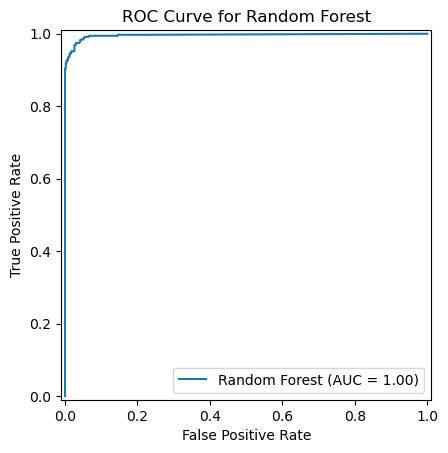

AUC: 0.9959


In [34]:
# positive/approved class predicted prob
y_prob = rf_search.predict_proba(X_test)[:, 1]

# roc curve and area
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='Rejected')
roc_auc = auc(fpr, tpr)

# plot
plt.figure(figsize=(8, 6))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest')
roc_display.plot()

plt.title('ROC Curve for Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

print(f'AUC: {roc_auc:.4f}')

## Discussion

In this project, I used a dataset containing loan approval information (found on Kaggle) to create, train, and evaluate a supervised machine learning model to predict into which class a loan application would fall: either 'Approved' or 'Rejected'. 

I began by doing some minor cleaning and classification of the data, followed by some exploratory data analysis and visualization: 
* The target class revealed an imbalance.
* The cateforical features left me doubting if they had much bearing on the outcome.
* The numerical features show strong collinearity between them.

Next up was constructing a pipeline through which to channel data:
* Data transformers to scale data/encode/...
* Pre-processor to apply appropriate transformers to the appropriate features
* Models to consider for this classification problem were:
    * Dummy classifier, for a baseline model (can't do worse than than, unless something goes wrong)
    * RBF SVM, with class balance addressed
    * kNN
    * Random Forest, with class balance addresses
* A loop through the models to guage their relative performance, which included saving the mean results of 5-fold cross-validation scores.

Feature selection came next:
* Chi-squared and p-values were used to assess the statistical importance of the categorical features. None were found to have a statistically significant relationship with the target.
* Variance Inflation Factors were calculated to assess the multi-collinearity of the model. Dropping income, luxury asset value and bank asset value features were found to greatly reduce the multi-collinearity of the model.
* After each round of feature removal, I remodelled and reassessed the relative changes to the models' performances. Changes were overall small.

The Random Forest model was chosen because, after removing the above features, it still had the best overall performance. Hyperparameters were then tuned. After an iterative process of adjusting the grid of parameters to search and visualizing the mean test scores, I found that:
* Best number of estimators: 18 
* Minimum number of samples to split: 19
* Max depth: 12

Evaluating the model:
* The model was tested on the X_test and Y_test data, and found to have a 97.07% accuracy on the unseen data.
* A confusion matrix and classification report were created further measure of model performance.
* The F1 score was 0.97
* ROC curve provides us with a visual on how the true positives compare to false positives - it looks good to me.
* AUC was 0.9954, which indicates the model is performing well.
  

#### Notice to readers
* The data and the model are quite simple and used for demonstration purposes only, not to be used in production for approving loans!

#### Further Improvements
* If I had used other methods of addressing the class imbalance at an earlier stage, kNN might have performed better.
* Statistical testing using paired t-test to determine whether the changed in the mean training and validation accuracy are statistically significant from zero, when features were removed. The changes were really small on this very simple dataset. On a larger and more complex model created for production purposes, this testing would be required.

* Ethical considerations: the global community has a diverse range of cultures. In some countries it may be completely legal to consider a borrowers gender or family status as part of the loan approval process, while in other countries it may not be. People within any particular culture are also highly diverse amoungst themselves. I'd like this small project to be yet another reminder of the impact that machine learning models could have on people who were not represented within the training data if they don't fit the mold. Having a loan approved could be the deciding factor in whether a borrower can get stable housing and climb their way out of poverty, or afford transportation to be able to access a wider job pool, or gain an education and make changes that affect not just themselves but their local community and beyond.

#### Conclusion:


### References

* The code structure for my preprocessor and pipeline comes from a course I had previous taken at the University of British Columbia, Extended Learning: FS031 Intro to Machine Learning. 
* Not going to lie, I used OpenAI to assist me with this project - mainly for the plotting the 3D graph, and a lot of debugging. Nothing was copied and pasted blindly, and I use it as a learning tool (it also steered my wrong a few times lol).
* DTSA 5509 lectures, projects, assignments and quizes were heavily referenced in all parts of this project.